# sofar and SOFA

If you are new to SOFA and/or sofar, this is a good place to start. SOFA is short for *Spatially Oriented Format for Acoustics* and is an open file format for saving acoustic data, such as head-related impulse responses (HRIRs), loudspeaker directivities, or room impulse responses measured with microphone arrays. Good places to get more information about SOFA after this introduction are

* The [SOFA paper](https://doi.org/10.17743/jaes.2022.0026)
* The documentation of the [SOFA conventions](https://sofar.readthedocs.io/en/stable/resources/conventions.html)
* [sofaconventions.org](https://www.sofaconventions.org)
* The SOFA standard [AES69-2022](https://www.aes.org/publications/standards/search.cfm?docID=99)

A complete documentation of the sofar package is given [here](https://sofar.readthedocs.io).

## Creating SOFA objects

To cover a variety of data, SOFA offers different *conventions*. A convention defines the data type, the required and optional meta data and the dimensions (shape) of the data and meta data. The data type can be

- TF: Transfer Function
- IR: Impulse Response
- SOS: Second Order Sections, and

Examples for meta data are
- A license
- Contact to the author of a SOFA file
- Positions of sources and receivers
 
You should always find the most specific convention for your data. This will help you to identify relevant meta data that you should provide along the actual acoustic data. sofar provides a list of conventions as part of the [online documentation](https://sofar.readthedocs.io/en/stable/resources/conventions.html) and as console output

In [ ]:
import sofar as sf
import os

sf.list_conventions()

You might have noticed that the data type (TF, IR, SOS) is part of the convention name and that it is appended by *-E* in some cases. This stands for *Emitter* and indicates that the convention is used to save data from multiple emitters (loud speakers).

Let us assume, that you want to store head-related impulse responses (HRIRs). In this case the most specific convention is *SimpleFreeFieldHRIR*. To create a SOFA object use

In [ ]:
sofa = sf.Sofa('SimpleFreeFieldHRIR')
print(sofa)

The return value `sofa` is a `sofar.Sofa` object filled with the default values of the *SimpleFreeFieldHRIR* convention. Note that you can also get a sofa object that has only the mandatory attributes by calling `sf.Sofa('SimpleFreeFieldHRIR', mandatory=True)`. However, it is recommended to start with all attributes and discard empty optional attributes before saving the data.

## Getting information about SOFA objects

A first impression of the data can be obtained with

In [ ]:
sofa.inspect()

This lists the names of all entries and a brief summary of the content. Lets take a closer look

* **Global Attributes** store meta data that describe the whole data stored in a SOFA file. Global attributes start with the keyword *GLOBAL* and are as stored as strings.
* **Variables** store numeric (double) or string data. Variables are always arrays. Example for Variables are the *SourcePosition* and *Data_IR*, which stores the actual acoustic data (impulse responses in this case).
* **Variable Attributes** store meta data describing a specific *variable* and are stored as stings. Variable attributes start with the name of the variable followed by an underscore and the name of the attribute. For example, *SourcePosition_Type* gives the *Type* of coordinates that are used to store data for the variable *SourcePosition*. An exception to this rule are the data variables, e.g, *Data_SamplingRate* is not an attribute but a double variable.

In the case of variables, the SOFA convention also specifies the *dimension* (called shape in numpy) that the data must have. For example *Data_IR* must be of shape $M \times R \times N$. In this case, $M=1$ denotes the number of source positions for which HRIRs are available, $R=2$ is the number of ears - which is two - and $N=1$ gives the lengths of the HRIRs in samples.

All dimensions can be obtained by

In [ ]:
sofa.list_dimensions

For SOFA files, the dimensions are automatically deduced from the data and the output tells us that for example the dimension $R=2$ was deduced from the shape of the variable *ReceiverPosition*. It is thus important to be aware of the dimensions and enter the data accordingly. In some cases, variables can have different shapes. An example for this is the *ReceiverPosition* which can be of shape $R \times C \times I$ or $R \times C \times M$.

The dimension *S* denotes the lengths of the longest string contained in a string variable. *S* is zero in this case, because the convention does not have any string variables. *C* denotes the size of coordinate points and is always three, because coordinates are either given by x, y, and z values or by their azimuth, elevation in degree and radius in meter (cf. [SOFA coordinate systems](https://www.sofaconventions.org/mediawiki/index.php/SOFA_specifications#Coordinate_system)).

To get a dimension as a variable, use

In [ ]:
sofa.get_dimension('N')

A complete description of each convention is given in the [sofar documentation](https://sofar.readthedocs.io/en/stable/resources/conventions.html). The documentation shows that data can be *mandatory*, *optional*, and *read only*.

## Getting and adding data to SOFA objects

Data can be obtained by simply calling attributes of the Sofa object, e.g.

In [ ]:
sofa.Data_IR

Note that all variables are stored as [numpy arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html), which means that you can use [indexing, and slicing](https://numpy.org/doc/stable/user/basics.indexing.html) just like with any other numpy array. For example you can get only the left ear data with

In [ ]:
sofa.Data_IR[:, 0]

Data can be added in the same way. The HRIRs and source position can for example be set with

In [ ]:
sofa.Data_IR = [[[1, 0, 0], [0, 0.5, 0]]]
sofa.SourcePosition = [90, 0, 1.5]

Now, the SOFA object contains a single HRIR - which is `[1, 0, 0]` for the left ear and `[0, 0.5, 0]` for the right ear - for a source at `90` degree azimuth, `0` degree elevation and a radius of `1.5` meter. Note that we entered lists and that sofar automatically converts the lists to numpy arrays. Sofar handles this in two steps:

1. When entering data as lists it is converted to a numpy array with at least two dimensions.
2. Missing dimensions are appended when writing the SOFA object to disk.

Normally, you would continue with filling all mandatory entries of the SOFA object. For this example we'll stop here for the sake of brevity. Let us, however, delete an optional entry that we do not need at this point

In [ ]:
sofa.delete('SourceUp')

In some cases you might want to add custom data. Although third party applications most likely won't make use of non-standardized data this can be useful for documentation and research use. Try this
to add a temperature value and unit. Note that you have to specify the data type and shape (dimensions) if you are adding SOFA variables

In [ ]:
sofa.add_variable('Temperature', 25.1, 'double', 'MI')
sofa.add_attribute('Temperature_Units', 'degree celsius')

After entering the data, the SOFA object should be verified to make sure that your data agrees with the SOFA standard and that if it can be read by other applications.

In [ ]:
sofa.verify()

This will check specific rules determined by the SOFA standard AES69 and general rules such as:

- Are all mandatory data contained?
- Are the names of variables and attributes in accordance with the SOFA
  standard?
- Are the data types in accordance with the SOFA standard?
- Are the dimensions of the variables consistent and in accordance
  to the SOFA standard?
- Are the values of attributes consistent and in accordance to the
  SOFA standard?

If any violations are detected, an error is raised.



## Reading and writing SOFA objects

Note that you usually do not need to call ``sofa.verify()`` separately because it is by default called if you create, write, or read a SOFA object. To write your SOFA object to disk type

In [ ]:
sf.write_sofa(os.path.join('..', '..', 'resources', 'my_first.sofa'), sofa)


It is good to know that SOFA files are essentially netCDF4 files which is
based on HDF5. They can thus be viewed with [HDF View](https://www.hdfgroup.org/downloads/hdfview/).

To read your sofa file you can use

In [ ]:
sofa_read = sf.read_sofa(os.path.join(
    '..', '..', 'resources', 'my_first.sofa'))

And to see that the written and read files contain the same data you can check

In [ ]:
sf.equals(sofa, sofa_read)

### Upgrading SOFA files

SOFA conventions might get updates to fix bugs in the conventions, in case new conventions are introduced, or in case conventions get deprecated. To find out if SOFA file is up to date, call `upgrade_convention` to get a list of upgrade choices or the information that the data is up to date.

In [ ]:
sofa.upgrade_convention()

## Stream SOFA files

SOFA files may be very large in which case you might not always want to read the entire file. To this end the `SofaStream` class can be used to

- read parts of the data
- inspect the data and dimensions

Lets stream some data from our first SOFA file

In [ ]:
filename = os.path.join('..', '..', 'resources', 'my_first.sofa')

with sf.SofaStream(filename) as file:

    # get information about shape of the variable Data_IR:
    # If a variable is accessed without indexing (i.e., without []) the type
    # and shape is can be obtained from the netCDF4.Variable
    data = file.Data_IR
    print(f'{data}\n')

    # read data for first receiver:
    # If a variable is accessed with indexing, only the requested data slice
    # is read directly from disk. In this case, the first channel is read.
    receiver_1 = file.Data_IR[:, 0]

print(receiver_1)

### Next steps

For detailed information about sofar please refer to the [sofar documentation](https://sofar.readthedocs.io).

# License notice
This notebook © 2024 by [the pyfar developers](https://github.com/orgs/pyfar/people) is licensed under [CC BY 4.0](http://creativecommons.org/licenses/by/4.0/?ref=chooser-v1)

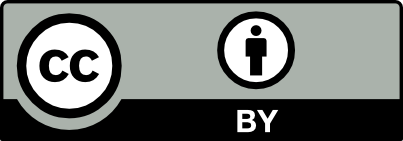


# Watermark

In [ ]:
%load_ext watermark
%watermark -v -m -iv